In [11]:
from PIL import Image
import torch.nn as nn
from torchvision import models

resnet152_pretrained = models.resnet152(pretrained=False)

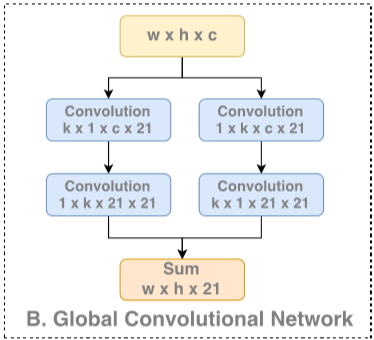

In [12]:
Image.open(r'E:\桌面\GCN.png')

In [13]:
class GCM(nn.Module):
    def __init__(self, in_channels, num_class, k=15):
        super(GCM, self).__init__()

        pad = (k-1) // 2

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, num_class, kernel_size=(1, k), padding=(0, pad), bias=False),
                                   nn.Conv2d(num_class, num_class, kernel_size=(k, 1), padding=(pad, 0), bias=False))

        self.conv2 = nn.Sequential(nn.Conv2d(in_channels, num_class, kernel_size=(k, 1), padding=(pad, 0), bias=False),
                                   nn.Conv2d(num_class, num_class, kernel_size=(1, k), padding=(0, pad), bias=False))

    def forward(self, x):

        x1 = self.conv1(x)
        x2 = self.conv2(x)

        assert x1.shape == x2.shape

        return x1 + x2

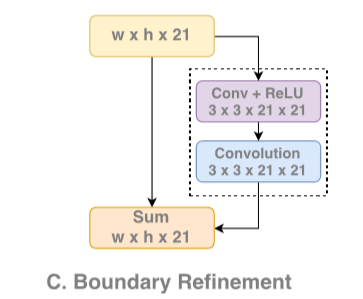

In [14]:
Image.open(r'E:\桌面\BR.png')

In [15]:
class BR(nn.Module):
    def __init__(self, num_class):
        super(BR, self).__init__()

        self.shortcut = nn.Sequential(nn.Conv2d(num_class, num_class, 3, padding=1, bias=False),
                                      nn.ReLU(),
                                      nn.Conv2d(num_class, num_class, 3, padding=1, bias=False))

    def forward(self, x):
        return x + self.shortcut(x)

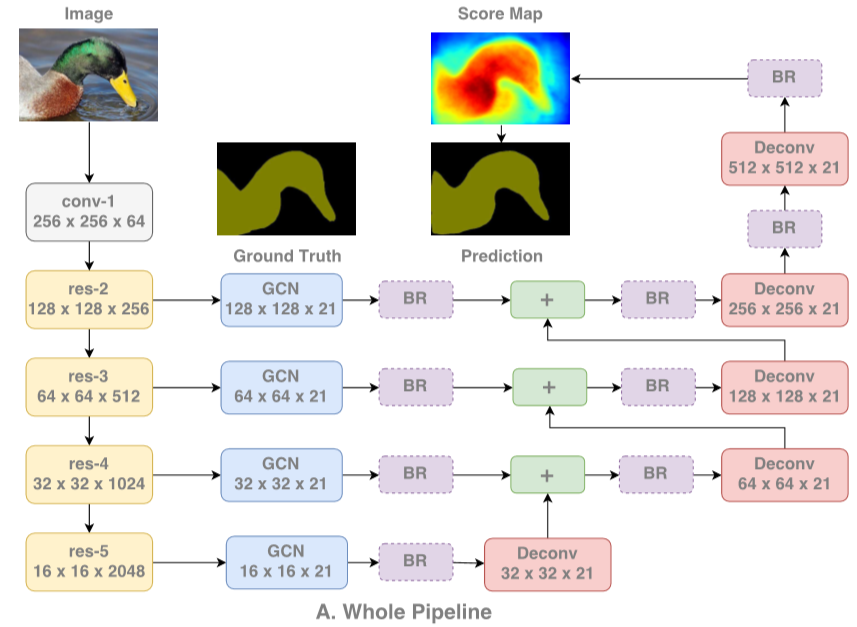

In [16]:
Image.open(r'E:\桌面\whole.png')

In [17]:
class GCN_BR_BR_Deconv(nn.Module):
    def __init__(self, in_channels, num_class, k=15):
        super(GCN_BR_BR_Deconv, self).__init__()

        self.gcn = GCM(in_channels, num_class, k)
        self.br = BR(num_class)

        self.deconv = nn.ConvTranspose2d(num_class, num_class, 4, 2, 1, bias=False)

    def forward(self, x1, x2=None):

        x1 = self.gcn(x1)
        x1 = self.br(x1)

        if x2 is None:
            x = self.deconv(x1)
        else:
            x = x1 + x2
            x = self.br(x)
            x = self.deconv(x)

        return x

In [18]:
class GCN(nn.Module):
    def __init__(self, num_classes, k=15):
        super(GCN, self).__init__()
        self.num_class = num_classes
        self.k = k

        self.layer0 = nn.Sequential(resnet152_pretrained.conv1, resnet152_pretrained.bn1, resnet152_pretrained.relu)
        self.layer1 = nn.Sequential(resnet152_pretrained.maxpool, resnet152_pretrained.layer1)
        self.layer2 = resnet152_pretrained.layer2
        self.layer3 = resnet152_pretrained.layer3
        self.layer4 = resnet152_pretrained.layer4

        self.br = BR(self.num_class)
        self.deconv = nn.ConvTranspose2d(self.num_class, self.num_class, 4, 2, 1, bias=False)

    def forward(self, input):
        x0 = self.layer0(input); print('x0:', x0.size())    # x0: torch.Size([1, 64, 176, 240])
        x1 = self.layer1(x0); print('x1:', x1.size())       # x1: torch.Size([1, 256, 88, 120])
        x2 = self.layer2(x1); print('x2:', x2.size())       # x2: torch.Size([1, 512, 44, 60])
        x3 = self.layer3(x2); print('x3:', x3.size())       # x3: torch.Size([1, 1024, 22, 30])
        x4 = self.layer4(x3); print('x4:', x4.size())       # x4: torch.Size([1, 2048, 11, 15])

        branch4 = GCN_BR_BR_Deconv(x4.shape[1], self.num_class, self.k)
        branch3 = GCN_BR_BR_Deconv(x3.shape[1], self.num_class, self.k)
        branch2 = GCN_BR_BR_Deconv(x2.shape[1], self.num_class, self.k)
        branch1 = GCN_BR_BR_Deconv(x1.shape[1], self.num_class, self.k)

        branch4 = branch4(x4); print('branch4:', branch4.size())    # torch.Size([1, 12, 22, 30])
        branch3 = branch3(x3, branch4); print('branch3:', branch3.size())   # torch.Size([1, 12, 44, 60])
        branch2 = branch2(x2, branch3); print('branch2:', branch2.size())   # torch.Size([1, 12, 88, 120])
        branch1 = branch1(x1, branch2); print('branch1:', branch1.size())   # torch.Size([1, 12, 176, 240])

        x = self.br(branch1)
        x = self.deconv(x)
        x = self.br(x)

        return x


In [19]:
if __name__ == "__main__":
    import torch as t
    rgb = t.randn(1, 3, 512, 512)

    net = GCN(21)

    out = net(rgb)

    print(out.shape)

x0: torch.Size([1, 64, 256, 256])
x1: torch.Size([1, 256, 128, 128])
x2: torch.Size([1, 512, 64, 64])
x3: torch.Size([1, 1024, 32, 32])
x4: torch.Size([1, 2048, 16, 16])
branch4: torch.Size([1, 21, 32, 32])
branch3: torch.Size([1, 21, 64, 64])
branch2: torch.Size([1, 21, 128, 128])
branch1: torch.Size([1, 21, 256, 256])
torch.Size([1, 21, 512, 512])
